In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r /content/drive/'My Drive'/'Colab Notebooks'/InfoSense/* . # Ignore this line if you have the notebook in the working directory

In [3]:
import vmo_copy
import vmo_copy.analysis as van
import librosa
import sklearn.preprocessing as pre
import numpy as np
import matplotlib.pyplot as plt
import os,pickle

%matplotlib inline

In [4]:
file_path = 'audio/flute' # Change this to match your computer
l = os.listdir(file_path)
f_list = [_l for _l in l if _l.endswith('wav')]

fft_size = 2048 
hop_size = 256 # 23ms 
sr = 22050

print(f_list)

['Nanguan - Dongxiao.wav', 'Shakuhachi - Flute.wav', 'Bach - Flute.wav', 'Teleman - Flute.wav', 'Teleman - Recorder.wav']


Nanguan - Dongxiao.wav is loaded,
Shakuhachi - Flute.wav is loaded,
Bach - Flute.wav is loaded,
Teleman - Flute.wav is loaded,
Teleman - Recorder.wav is loaded,


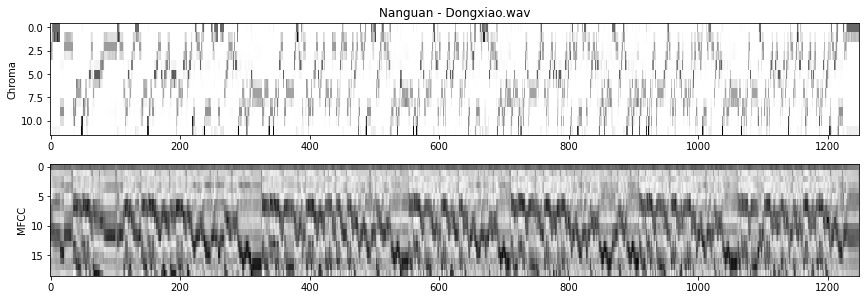

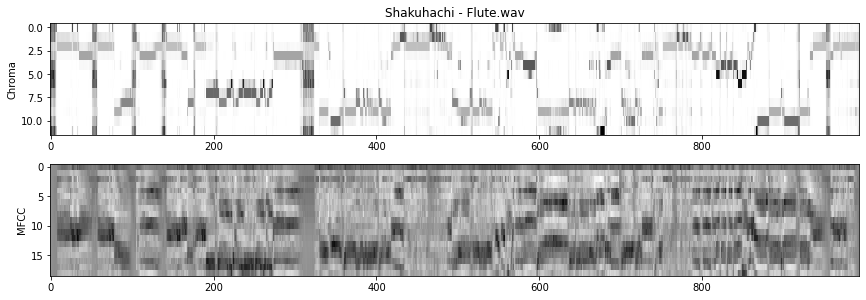

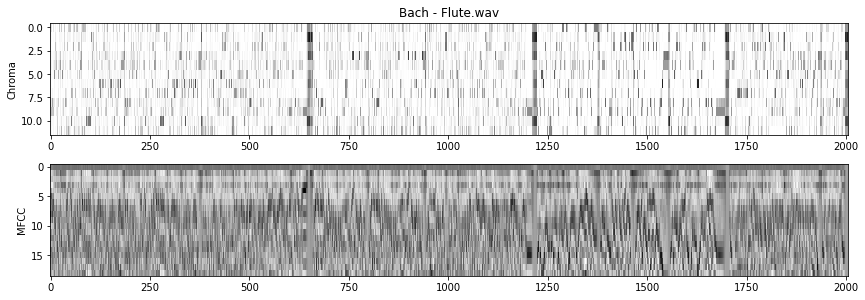

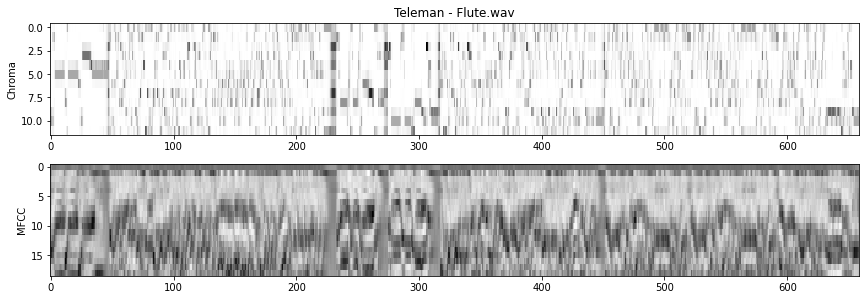

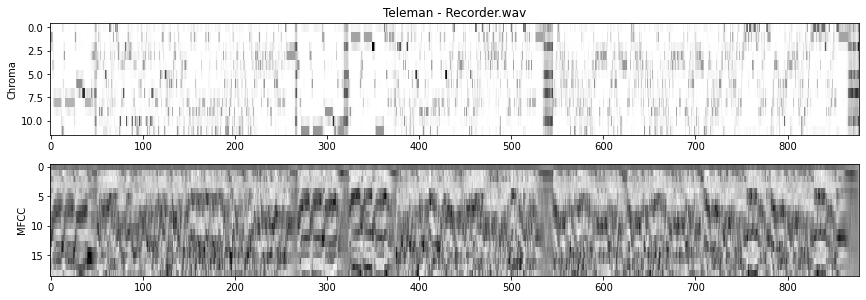

In [10]:
c_raw_list = []
m_raw_list = []
c_beat_list = []
m_beat_list = []
b_list = []
t_list = []

for f in f_list:
    y, sr = librosa.load(file_path+'/'+f, sr = sr)
    s = np.abs(librosa.core.stft(y=y, n_fft=fft_size, hop_length=hop_size))
    print(f + ' is loaded,')
    
    beats = np.arange(0, s.shape[1], 24)
    b_list.append(beats)
    
    C = librosa.feature.chroma_stft(y=y, sr=sr, S = s**2, n_fft=fft_size, hop_length=hop_size)
    C = pre.normalize(C)
    C_sync = librosa.util.sync(C, beats, aggregate = np.mean)
    c_raw_list.append(C)
    c_beat_list.append(C_sync)
    
    #S = librosa.feature.melspectrogram(y=y, sr=sr, S = s**2, n_fft=fft_size, hop_length=hop_size, n_mels=128)
    #log_S = librosa.amplitude_to_db(S, ref=np.max)
    M = librosa.feature.mfcc(y=y, n_fft=fft_size, hop_length=hop_size, n_mels=128, n_mfcc=20)
    _M = M[1:]
    _M = pre.normalize(_M)
    m_raw_list.append(_M)
    M_sync = librosa.util.sync(_M, beats, aggregate = np.mean)
    m_beat_list.append(M_sync)
            
    
    plt.figure(figsize = (12,6))
    plt.subplot(311)
    plt.title(f)
    plt.imshow(C_sync, aspect = 'auto', interpolation = 'nearest', cmap = 'Greys')
    plt.ylabel('Chroma')
    plt.subplot(312)
    plt.imshow(M_sync, aspect = 'auto', interpolation = 'nearest', cmap = 'Greys')
    plt.ylabel('MFCC')
    plt.tight_layout()

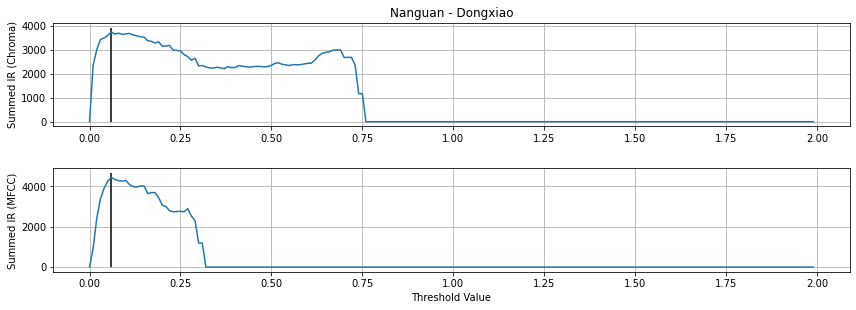

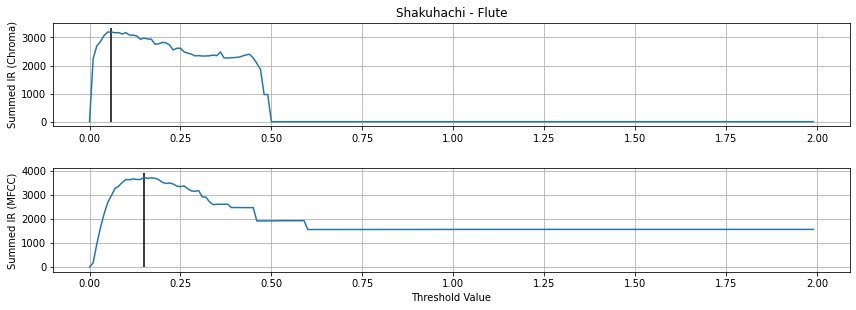

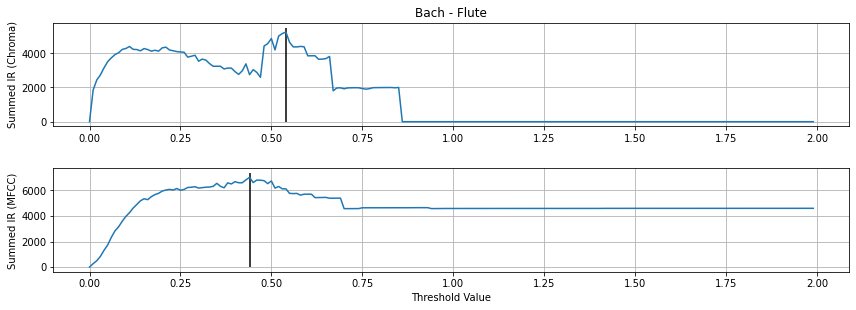

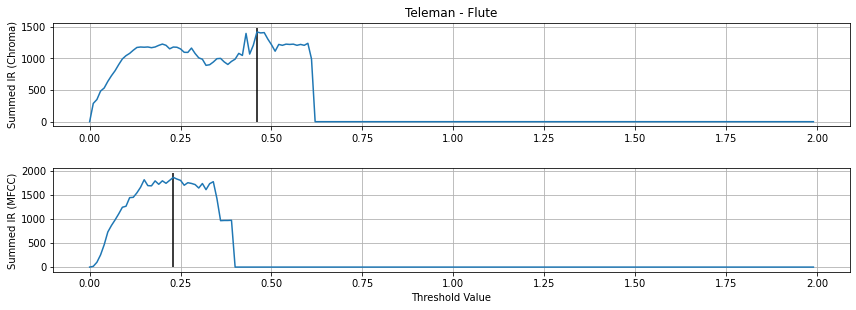

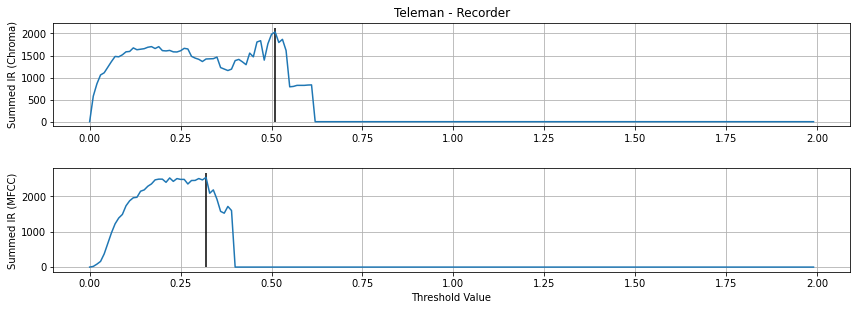

In [11]:
min_len = 2

r = (0., 2.0, 0.01)
r_c = (0.0,0.06,0.0003)
r_m = (0.0,0.06,0.0003)
r_c = r
r_m = r

oracle_c_vec = []
oracle_m_vec = []
pattern_c_vec = []
pattern_m_vec = []
ir_c_vec = []
ir_m_vec = []
for chroma,mfcc,f in zip(c_beat_list,m_beat_list,f_list):
    
    ideal_t_c = vmo_copy.find_threshold(chroma.T, r = r_c, dim=chroma.shape[0])
    oracle_c = vmo_copy.build_oracle(chroma.T, flag = 'a',
                                threshold = ideal_t_c[0][1], 
                                feature = 'chroma', dim=chroma.shape[0])
    oracle_c_vec.append(oracle_c)
    pattern_c = van.find_repeated_patterns(oracle_c, lower = min_len)
    pattern_c_vec.append(pattern_c)
    
    x_c = [j[1] for j in ideal_t_c[1]]
    y_c = [j[0] for j in ideal_t_c[1]]
    ir_c_vec.append(ideal_t_c)
    
    ideal_t_m = vmo_copy.find_threshold(mfcc.T, r = r_m,dim = mfcc.shape[0])
    oracle_m = vmo_copy.build_oracle(mfcc.T, flag = 'a',
                                threshold = ideal_t_m[0][1], 
                                feature = 'mfcc', dim=mfcc.shape[0])
    oracle_m_vec.append(oracle_m)
    pattern_m = van.find_repeated_patterns(oracle_m, lower = min_len)
    pattern_m_vec.append(pattern_m)
    
    x_m = [j[1] for j in ideal_t_m[1]]
    y_m = [j[0] for j in ideal_t_m[1]]
    ir_m_vec.append(ideal_t_m)


    plt.figure(figsize = (12,6))
    plt.subplot(311)
    plt.plot(x_c, y_c)
    ymin, ymax = plt.ylim()
    plt.vlines(ideal_t_c[0][1], 0, ymax)
    plt.title(f[:-4])
    plt.ylabel('Summed IR (Chroma)')
    plt.grid('on')
    plt.subplot(312)
    plt.plot(x_m, y_m)
    ymin, ymax = plt.ylim()
    plt.vlines(ideal_t_m[0][1], 0, ymax)
    plt.grid('on')
    plt.ylabel('Summed IR (MFCC)')
    plt.grid('on')
    plt.xlabel('Threshold Value')
    plt.tight_layout()

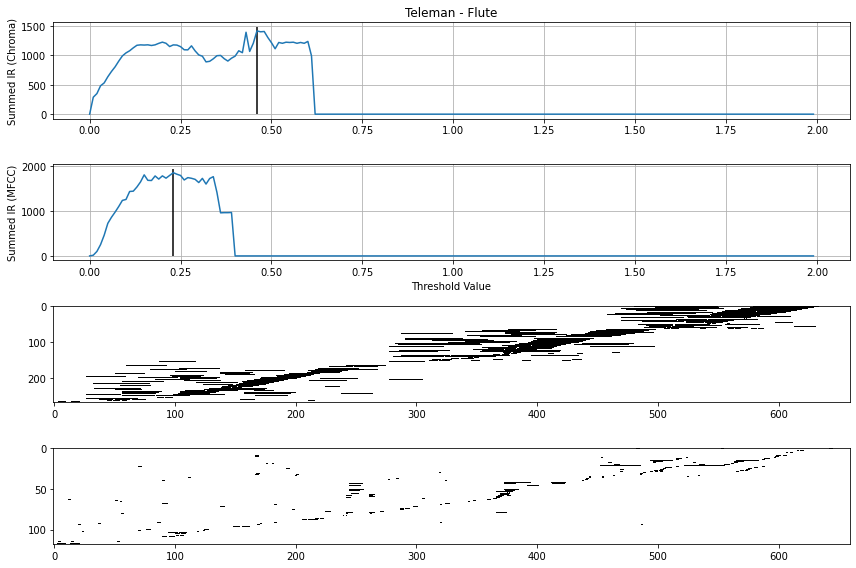

In [16]:
chroma = c_beat_list[3]
mfcc = m_beat_list[3]
f = f_list[3]

ideal_t_c = vmo_copy.find_threshold(chroma.T, r = r_c, dim=chroma.shape[0])
oracle_c = vmo_copy.build_oracle(chroma.T, flag = 'a',
                            threshold = ideal_t_c[0][1], 
                            feature = 'chroma', dim=chroma.shape[0])

pattern = van.find_repeated_patterns(oracle_c, lower=2)
pattern_mat_c = np.zeros((len(pattern), oracle_c.n_states-1))
for i,p in enumerate(pattern):
    length = p[1]
    for s in p[0]:
        pattern_mat_c[i][s-length:s-1] = 1

x_c = [j[1] for j in ideal_t_c[1]]
y_c = [j[0] for j in ideal_t_c[1]]



ideal_t_m = vmo_copy.find_threshold(mfcc.T, r = r_m,dim = mfcc.shape[0])
oracle_m = vmo_copy.build_oracle(mfcc.T, flag = 'a',
                            threshold = ideal_t_m[0][1], 
                            feature = 'mfcc', dim=mfcc.shape[0])

pattern = van.find_repeated_patterns(oracle_m, lower=2)
pattern_mat_m = np.zeros((len(pattern), oracle_m.n_states-1))
for i,p in enumerate(pattern):
    length = p[1]
    for s in p[0]:
        pattern_mat_m[i][s-length:s-1] = 1

x_m = [j[1] for j in ideal_t_m[1]]
y_m = [j[0] for j in ideal_t_m[1]]

plt.figure(figsize = (12,8))
plt.subplot(411)
plt.plot(x_c, y_c)
ymin, ymax = plt.ylim()
plt.vlines(ideal_t_c[0][1], 0, ymax)
plt.title(f[:-4])
plt.ylabel('Summed IR (Chroma)')
plt.grid('on')
plt.subplot(412)
plt.plot(x_m, y_m)
ymin, ymax = plt.ylim()
plt.vlines(ideal_t_m[0][1], 0, ymax)
plt.grid('on')
plt.ylabel('Summed IR (MFCC)')
plt.grid('on')
plt.xlabel('Threshold Value')
plt.subplot(413)
plt.imshow(pattern_mat_c, interpolation = 'nearest', aspect = 'auto', cmap = 'Greys')
plt.subplot(414)
plt.imshow(pattern_mat_m, interpolation = 'nearest', aspect = 'auto', cmap = 'Greys')
plt.tight_layout()

In [18]:
f_list

['Nanguan - Dongxiao.wav',
 'Shakuhachi - Flute.wav',
 'Bach - Flute.wav',
 'Teleman - Flute.wav',
 'Teleman - Recorder.wav']

In [19]:
import pickle

songs = ['nanguan', 'shakuhachi', 'bach', 'telemanF', 'telemanR']

for song, chroma, ir, oracle in zip(songs, c_beat_list, ir_c_vec, oracle_c_vec):
    config = 'chroma'
    pickle_file = '%s_%s_vmo.pkl'%(song,config)
    with open(pickle_file, 'wb') as f:
        pickle.dump(chroma, f)
        pickle.dump(ir, f)
        pickle.dump(oracle, f)
    !cp {pickle_file} /content/drive/'My Drive'/'Colab Notebooks'/InfoSense/models/{pickle_file}

for song, mfcc, ir, oracle in zip(songs, m_beat_list, ir_m_vec, oracle_m_vec):
    config = 'mfcc'
    pickle_file = '%s_%s_vmo.pkl'%(song,config)
    with open(pickle_file, 'wb') as f:
        pickle.dump(mfcc, f)
        pickle.dump(ir, f)
        pickle.dump(oracle, f)
    !cp {pickle_file} /content/drive/'My Drive'/'Colab Notebooks'/InfoSense/models/{pickle_file}